# Experiment II: Relative confidence with custom weighting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Prepare graphs

In [4]:
from hypotest.ontologies import molecular_subgraph, full_graph
from grontocrawler.graph import produce_graph
from hypotest.graph_mutation import normalize_hypothgraph

sub_onto = molecular_subgraph.g
full_onto = full_graph.g

sub_unnorm = produce_graph.produce_graph(sub_onto, options=['existential-arcs'])
full_unnorm = produce_graph.produce_graph(full_onto, options=['existential-arcs'])

sub_norm, _ = normalize_hypothgraph.normalize_hypothgraph(sub_unnorm)
full_norm, _ = normalize_hypothgraph.normalize_hypothgraph(full_unnorm)

INFO:rdflib:RDFLib Version: 4.2.1


## Configuration

In [5]:
from hypotest.graph_generation import hypoth_conf
Hypoth_Conf = hypoth_conf.Hypoth_Conf
conf_source, conf_target = hypoth_conf.generate_max_endpoints(sub_norm)
print(conf_source, conf_target)

(u'http://plumdeq.xyz/ontologies/hypothesis/Positive_regulation_of_Chondrocytes_catabolic_activity', 'http://plumdeq.xyz/ontologies/hypothesis/Loss_of_collagen')


## Custom weighting

### Random weiths

It is random which we define on the big graph

In [18]:
import random

random_weights = {}
for node in full_norm.nodes_iter():
    random_weights[node] = random.random()
    
def rand_func_import(hypothgraph, node):
    return random_weights[node]

Favor interior nodes from the subgraph

In [19]:
from hypotest.graph_generation import boundary

interior_full = list(boundary.in_boundary_interior(
    full_norm, conf_source, conf_target))
interior_sub = list(boundary.in_boundary_interior(
    sub_norm, conf_source, conf_target))
outside_sub_in_full = [x for x in interior_full if not x in interior_sub]

def favor_sub_func_import(hypothgraph, node):
    # give big score to those in sub
    if node in interior_sub:
        return 1.0
    # low priority to those not in sub but in full
    if node in outside_sub_in_full:
        return 0.1
    
    return random.random()

In [20]:
def favor_sub_harsh_func_import(hypothgraph, node):
    # give big score to those in sub
    if node in interior_sub:
        return 1.0
    # low priority to those not in sub but in full
    if node in outside_sub_in_full:
        return 0.01
    
    return random.random()

Favor outside nodes from the subgraph

In [21]:
def favor_full_func_import(hypothgraph, node):
    # give big score to those in sub
    if node in interior_sub:
        return 0.1
    # low priority to those not in sub but in full
    if node in outside_sub_in_full:
        return 1.0
    
    return random.random()

## Computing confidences

Define the importance function with `my_func_import`

In [22]:
from hypotest.confidence.compute_confidence import default_node_importance_measure
# my_func_import = default_node_importance_measure
# my_func_import = favor_full_func_import
my_func_import = rand_func_import
# my_func_import = favor_sub_func_import

In [23]:
from hypotest.stats import confidences

sub_unnormalized_confidences = confidences.confidence_spectrum(
    sub_norm, conf_source, conf_target, normalized=False, 
    func_importance=my_func_import)
sub_normalized_confidences = confidences.confidence_spectrum(
    sub_norm, conf_source, conf_target, normalized=True,
    func_importance=my_func_import)

In [24]:
full_unnormalized_confidences = confidences.confidence_spectrum(
    full_norm, conf_source, conf_target, normalized=False,
    func_importance=my_func_import)
full_normalized_confidences = confidences.confidence_spectrum(
    full_norm, conf_source, conf_target, normalized=True,
    func_importance=my_func_import)

In [25]:
max_full_unnorm = np.max(full_unnormalized_confidences)[0]
sub_norm_to_big = [np.array(x)/max_full_unnorm for x in sub_unnormalized_confidences]

## Squared mean errors

Compute confidences for different weighting schemes

In [26]:
schemes = {
    'default': default_node_importance_measure, 
    'random': rand_func_import,
    'favor_sub': favor_sub_func_import,
    'favor_sub_harsh': favor_sub_harsh_func_import,
    'favor_full': favor_full_func_import
}

In [27]:
def error_scheme(scheme):
    sub_un = confidences.confidence_spectrum(
        sub_norm, conf_source, conf_target, normalized=False, 
        func_importance=scheme)
    full_un = confidences.confidence_spectrum(
        full_norm, conf_source, conf_target, normalized=False, 
        func_importance=scheme)
    sub_n = confidences.confidence_spectrum(
        sub_norm, conf_source, conf_target, normalized=True, 
        func_importance=scheme)
    full_n = confidences.confidence_spectrum(
        full_norm, conf_source, conf_target, normalized=True, 
        func_importance=scheme)
    
    max_full_u = np.max(full_un)[0]
    sub_n_big = [np.array(x)/max_full_u for x in sub_un]
    
    mean_sub_n = np.array([np.mean(x) for x in sub_n])
    mean_sub_n_big = np.array([np.mean(x) for x in sub_n_big])
    
    error = mean_sub_n - mean_sub_n_big
    
    return error.dot(error)

In [28]:
for scheme in schemes:
    f = schemes[scheme]
    print('For scheme {} error is {}'.format(scheme, error_scheme(f)))

For scheme default error is 2.17214663643
For scheme favor_full error is 2.9639012253
For scheme favor_sub error is 1.95119293127
For scheme random error is 2.09116899903
For scheme favor_sub_harsh error is 1.92515964


## Plot confidences

In [29]:
from matplotlib import pyplot as plt

In [30]:
# When we plot confidences we need to take into account 'bigger' and 
# 'smaller' 
# graphs, i.e., the sizes of the confidence vectors might not be the same
def plot_confidences(bigger, smaller, bigger_label=None, 
                     smaller_label=None, 
                     legend_loc='upper left',
                     xlabel="",
                     ylabel=""):
    # Determine xs
    x_s = range(len(smaller))
    x_b = range(len(bigger))
    
    min_x = min(x_b)
    max_x = max(x_b)
    # min max of ys, they are list of lists
    min_y = np.min(bigger)[0]
    max_y = np.max(bigger)[0]
    
    # figure where you draw everything
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    # offsets for the plots
    offset_x = max(x_b) * 0.05
    offset_y = max_y * 0.05

    ax.set_xlim(min_x - offset_x, max_x + offset_x)
    ax.set_ylim(min_y - offset_y, max_y + offset_y)
    
    # Draw distributions
    ax.violinplot(smaller, x_s)
    ax.violinplot(bigger, x_b)
    
    # Compute the means
    smaller_means = [np.mean(x) for x in smaller]
    bigger_means = [np.mean(x) for x in bigger]
    
    # Draw the mean line
    ax.plot(smaller_means, 'o--', markersize=3.0, label=smaller_label)
    ax.plot(bigger_means, 'o--', markersize=3.0, label=bigger_label)
    
    # Annotations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, fontsize=16)
    
    ax.legend(fontsize=10.0, loc=legend_loc)
    
    return fig, ax

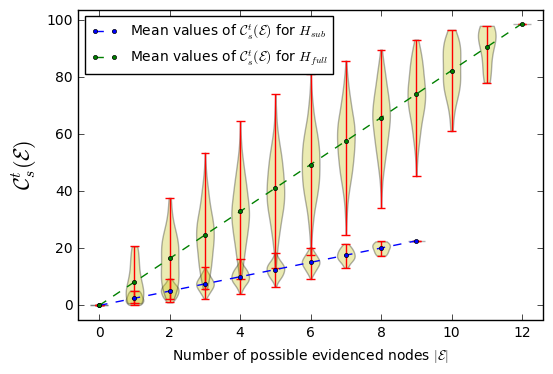

In [31]:
fig1, ax1 = plot_confidences(full_unnormalized_confidences, 
                 sub_unnormalized_confidences,
                 smaller_label='Mean values of $\mathcal{C}_s^t(\mathcal{E})$ for $H_{sub}$',
                 bigger_label='Mean values of $\mathcal{C}_s^t(\mathcal{E})$ for $H_{full}$',
                 xlabel=r'Number of possible evidenced nodes $|\mathcal{E}|$',
                 ylabel=r'$\mathcal{C}_s^t(\mathcal{E})$')

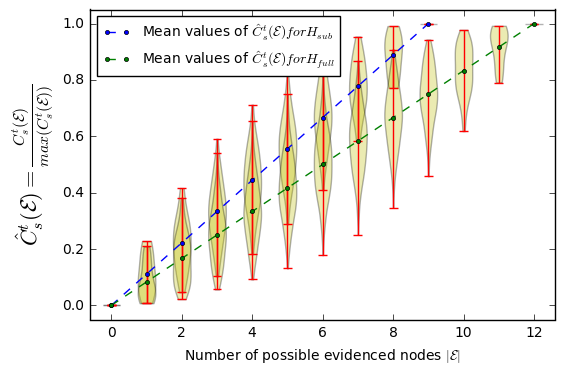

In [32]:
fig2, ax2 = plot_confidences(full_normalized_confidences, 
                 sub_normalized_confidences,
                 smaller_label=r"Mean values of $\hat{C}_s^t(\mathcal{E}) for H_{sub}$",
                 bigger_label=r"Mean values of $\hat{C}_s^t(\mathcal{E}) for H_{full}$",
                 xlabel=r"Number of possible evidenced nodes $|\mathcal{E}|$",
                 ylabel=r"$\hat{C}_s^t(\mathcal{E}) = \frac{C_s^t(\mathcal{E})}{max(C_s^t(\mathcal{E}))}$")

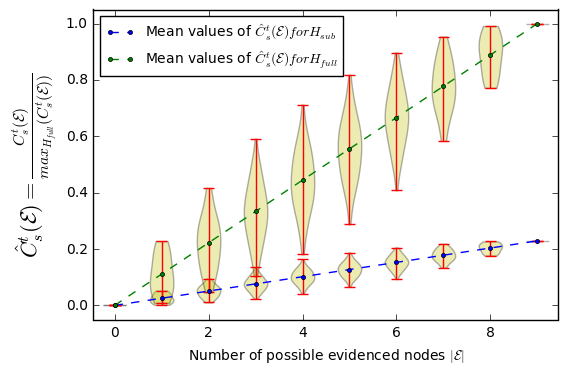

In [33]:
fig3, ax3 = plot_confidences(sub_normalized_confidences, 
                 sub_norm_to_big,
                 smaller_label=r"Mean values of $\hat{C}_s^t(\mathcal{E}) for H_{sub}$",
                 bigger_label=r"Mean values of $\hat{C}_s^t(\mathcal{E}) for H_{full}$",
                 xlabel=r"Number of possible evidenced nodes $|\mathcal{E}|$",
                 ylabel=r"$\hat{C}_s^t(\mathcal{E}) = \frac{C_s^t(\mathcal{E})}{max_{H_{full}}(C_s^t(\mathcal{E}))}$")